# VN30 Time Series Prediction with TensorFlow
This notebook loads VN30 stock data, lets you pick a ticker, trains Linear, NLinear, DLinear models, and plots forecasts.
# Chạy lần lượt từng cell , thay ticket ở cell cuôi để thay mã stock.

In [268]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

DATA_DIR = "./stock_data_vn30_480days"
TIME_COL = "time"
PRICE_COL = "close"
PRED_LEN = 7
SEQ_LENS = [7,30,180,360]


In [269]:
def load_data(ticker):
    # Tìm file có tên chứa ticker, ví dụ: ACB_480days_daily.csv
    files = os.listdir(DATA_DIR)
    match = None
    for f in files:
        if ticker.upper() in f.upper() and f.endswith(".csv"):
            match = os.path.join(DATA_DIR, f)
            break
    if match is None:
        raise FileNotFoundError(f"Không tìm thấy file cho ticker {ticker} trong folder {DATA_DIR}")

    df = pd.read_csv(match)

    # Chuẩn hoá tên cột
    if TIME_COL not in df.columns:
        # tự đoán cột thời gian
        for c in ["time","date","Date","datetime"]:
            if c in df.columns:
                df.rename(columns={c: TIME_COL}, inplace=True)
                break

    if PRICE_COL not in df.columns:
        # tự đoán cột giá
        for c in ["close","Close","close_price","adj_close"]:
            if c in df.columns:
                df.rename(columns={c: PRICE_COL}, inplace=True)
                break

    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    return df



In [270]:

def create_sequences(series, seq_len, pred_len):
    X, Y = [], []
    for i in range(len(series)-seq_len-pred_len+1):
        X.append(series[i:i+seq_len])
        Y.append(series[i+seq_len:i+seq_len+pred_len])
    return np.array(X), np.array(Y)


In [271]:

class LinearTF(tf.keras.Model):
    def __init__(self, seq_len, pred_len):
        super().__init__()
        self.d = tf.keras.layers.Dense(pred_len)
    def call(self, x):
        return self.d(x)

class NLinearTF(tf.keras.Model):
    def __init__(self, seq_len, pred_len):
        super().__init__()
        self.d = tf.keras.layers.Dense(pred_len)
    def call(self, x):
        last = x[:,-1:]
        x_norm = x - last
        pn = self.d(x_norm)
        return pn + last

class DLinearTF(tf.keras.Model):
    def __init__(self, seq_len, pred_len, ma=5):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(pred_len)
        self.d2 = tf.keras.layers.Dense(pred_len)
        kernel = tf.ones((ma,1,1))/ma
        self.kernel = tf.Variable(kernel, trainable=False)
    def decompose(self, x):
        xe = tf.expand_dims(x,2)
        trend = tf.nn.conv1d(xe, self.kernel, 1, "SAME")
        trend = tf.squeeze(trend,2)
        seas = x - trend
        return trend, seas
    def call(self, x):
        t,s = self.decompose(x)
        return self.d1(t)+self.d2(s)


In [272]:

def train_model(model, Xtr, Ytr, Xval, Yval):
    model.compile(optimizer='adam', loss='mse')
    model.fit(Xtr, Ytr, validation_data=(Xval,Yval), epochs=40, verbose=0)
    return model


In [273]:
def run_seq(prices, seq_len):
    # Tạo sequence train: dùng toàn bộ dữ liệu trừ 7 ngày cuối
    train_prices = prices[:-PRED_LEN]
    test_prices  = prices[-(seq_len+PRED_LEN):]   # seq để predict + 7 ngày thực

    # train sequences
    X_train, Y_train = create_sequences(train_prices, seq_len, PRED_LEN)

    # test sequence (1 mẫu duy nhất)
    X_test = test_prices[:seq_len].reshape(1, seq_len)
    Y_test = test_prices[seq_len:].reshape(1, PRED_LEN)

    # scale theo train
    sx = StandardScaler()
    sy = StandardScaler()
    X_train_s = sx.fit_transform(X_train)
    Y_train_s = sy.fit_transform(Y_train)

    X_test_s = sx.transform(X_test)

    # Train 3 models
    m1 = LinearTF(seq_len, PRED_LEN)
    m2 = NLinearTF(seq_len, PRED_LEN)
    m3 = DLinearTF(seq_len, PRED_LEN)

    m1.compile(loss="mse", optimizer="adam")
    m2.compile(loss="mse", optimizer="adam")
    m3.compile(loss="mse", optimizer="adam")

    m1.fit(X_train_s, Y_train_s, epochs=50, verbose=0)
    m2.fit(X_train_s, Y_train_s, epochs=50, verbose=0)
    m3.fit(X_train_s, Y_train_s, epochs=50, verbose=0)

    # Predict
    p1 = sy.inverse_transform(m1.predict(X_test_s))
    p2 = sy.inverse_transform(m2.predict(X_test_s))
    p3 = sy.inverse_transform(m3.predict(X_test_s))

    # return 7 ngày thực tế + 3 đường dự đoán
    return Y_test.flatten(), p1.flatten(), p2.flatten(), p3.flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


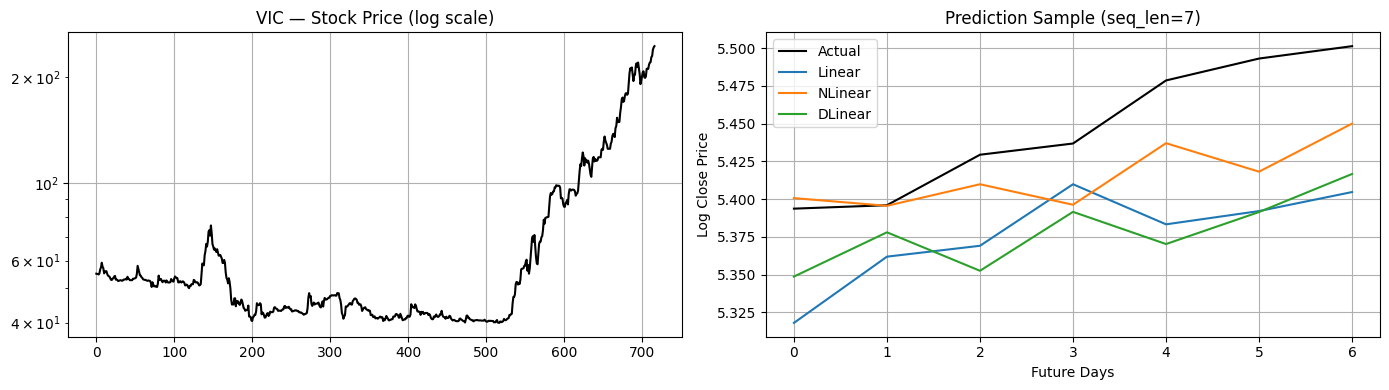

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


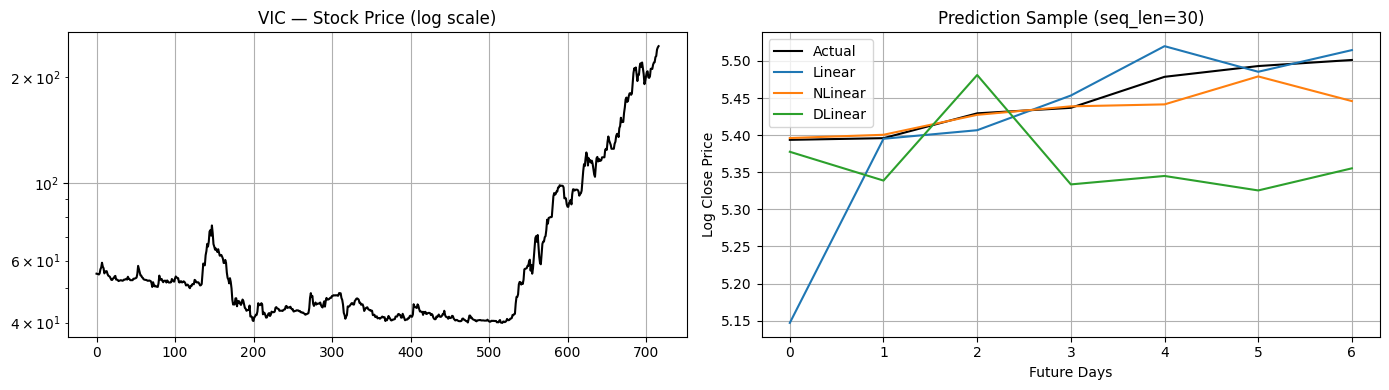

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


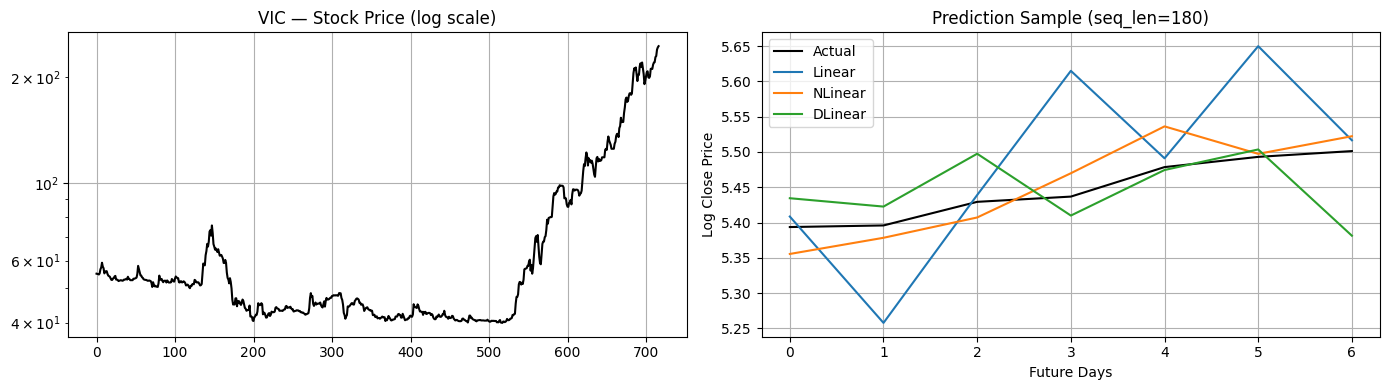

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


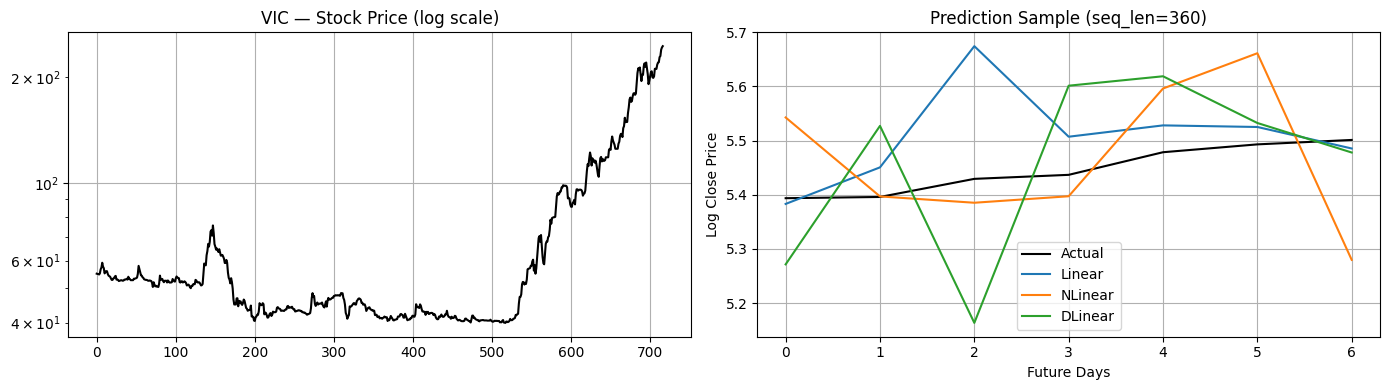

In [ ]:
ticker = "VIC"
df = load_data(ticker)
prices = df[PRICE_COL].values.astype(float)

for seq in SEQ_LENS:
    if len(prices) < seq + PRED_LEN:
        print(f"⚠️ Bỏ qua seq_len={seq} vì dữ liệu không đủ ({len(prices)} < {seq+PRED_LEN})")
        continue

    y_true, p1, p2, p3 = run_seq(prices, seq)

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # (A) Stock Price — Log Scale
    axes[0].plot(prices, color="black")
    axes[0].set_title(f"{ticker} — Stock Price (log scale)")
    axes[0].set_yscale("log")
    axes[0].grid(True)

    # (B) Prediction Sample 
    days = range(PRED_LEN)
    y_true_log = np.log(y_true)
    p1_log = np.log(p1)
    p2_log = np.log(p2)
    p3_log = np.log(p3)
    axes[1].plot(days, y_true_log, label="Actual", color="black")
    axes[1].plot(days, p1_log, label="Linear")
    axes[1].plot(days, p2_log, label="NLinear")
    axes[1].plot(days, p3_log, label="DLinear")
    axes[1].set_title(f"Prediction Sample (seq_len={seq})")
    axes[1].set_xlabel("Future Days")
    axes[1].set_ylabel("Log Close Price")
    axes[1].grid(True)
    axes[1].legend()
    plt.tight_layout()
    plt.show()